#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install lightgbm

Импортируем библиотеки, с которыми будем работать

In [2]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import time
import warnings
warnings.filterwarnings('ignore')

Сохраним данные в переменную `df` и посмотрим первые 5 строк датасета:

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице с заказами такси интервал 10 минут, всего один столбец с количеством заказов `num_orders`. Всего 26496 строк, пропущенных значений нет, особой предобработки данных не требуется. Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы `is_monotonic`:

In [6]:
df.index.is_monotonic

True

Данные расположены в хронологическом порядке с 1 марта 2018 года по 31 августа 2018 года. Посмотрим описательную статистику:

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Максимальное количество заказов за 10 минут = 119 заказов. Для решения нашей задачи проведем ресемплирование данных по одному часу.

In [8]:
df = df.resample('1H').sum()
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Подготовили данные к дальнейшему анализу.

## Анализ

Построим график заказов такси по часам за весь период с марта по август 2018 года.

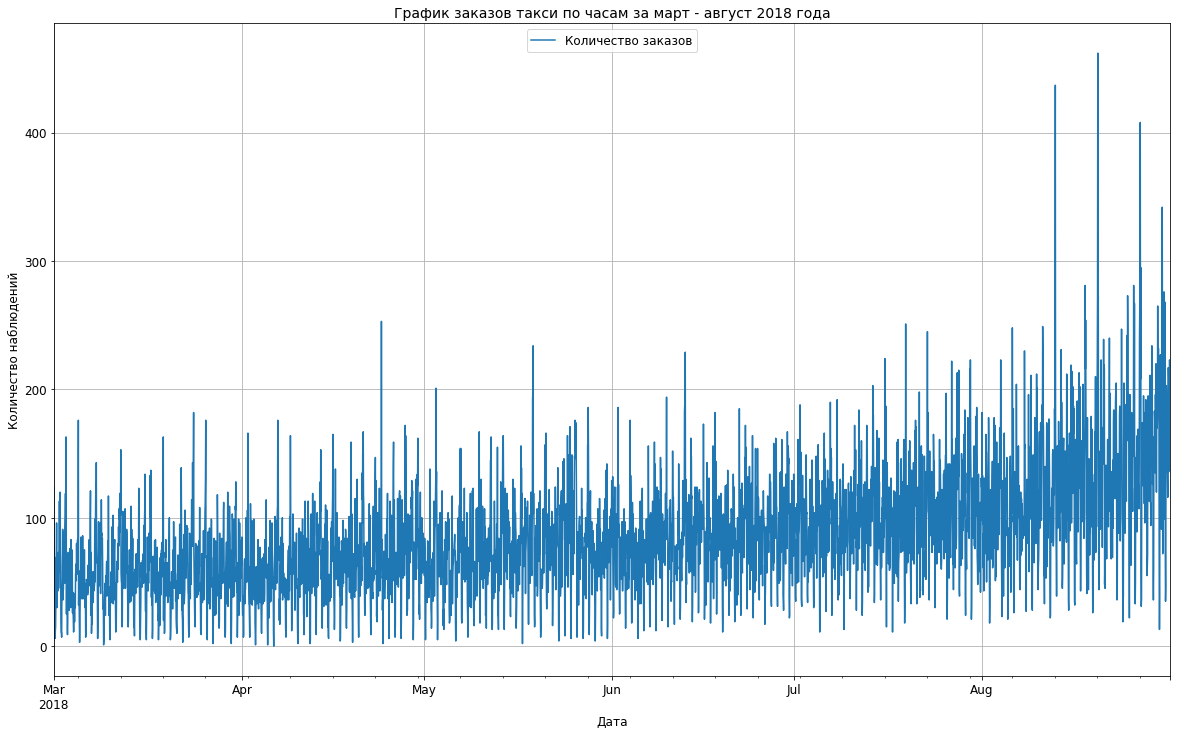

In [9]:
df.plot(grid=True, figsize=(20, 12), fontsize=(12))
plt.title('График заказов такси по часам за март - август 2018 года', size=14)
plt.xlabel('Дата', size=12)
plt.ylabel('Количество наблюдений', size=12)
plt.legend(['Количество заказов'], loc = 9, fontsize = 12)
plt.show()

### Скользящее среднее

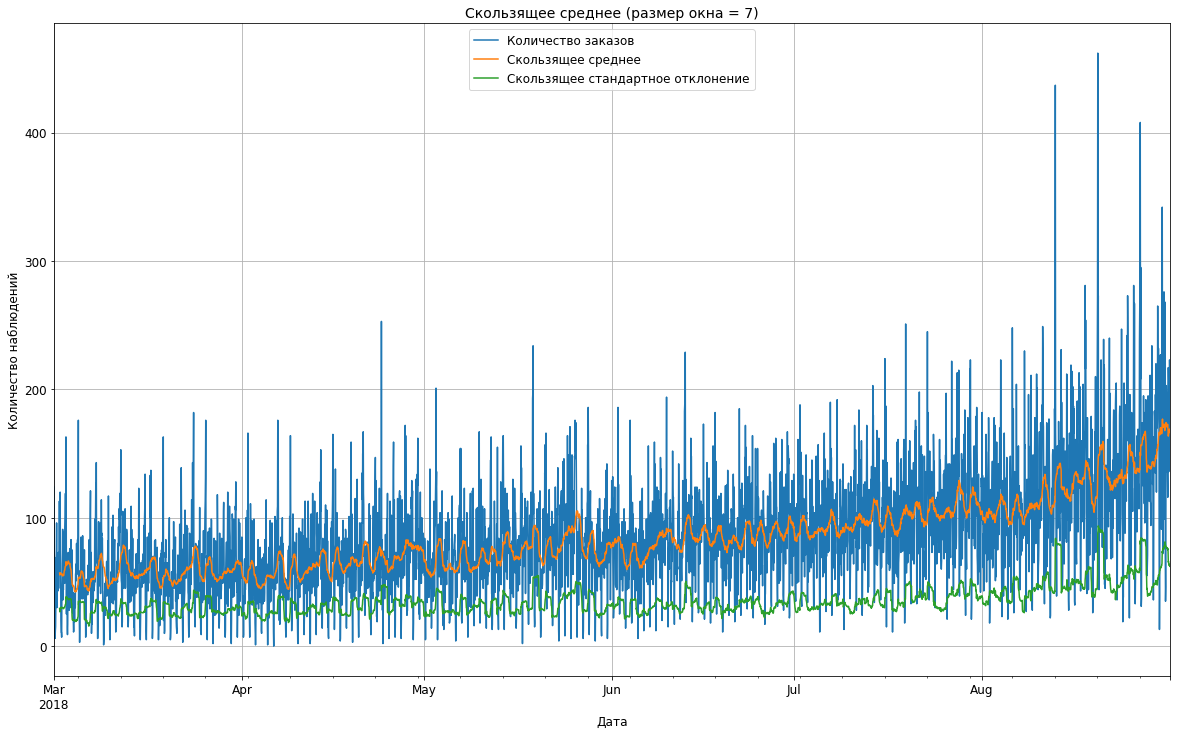

In [10]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot(grid=True, figsize=(20, 12), fontsize=(12))
plt.title('Скользящее среднее (размер окна = 7)', size=14)
plt.xlabel('Дата', size=12)
plt.ylabel('Количество наблюдений', size=12)
plt.legend(['Количество заказов', 'Скользящее среднее', 'Скользящее стандартное отклонение'], loc = 9, fontsize = 12)
plt.show()

### Тренды и сезонность

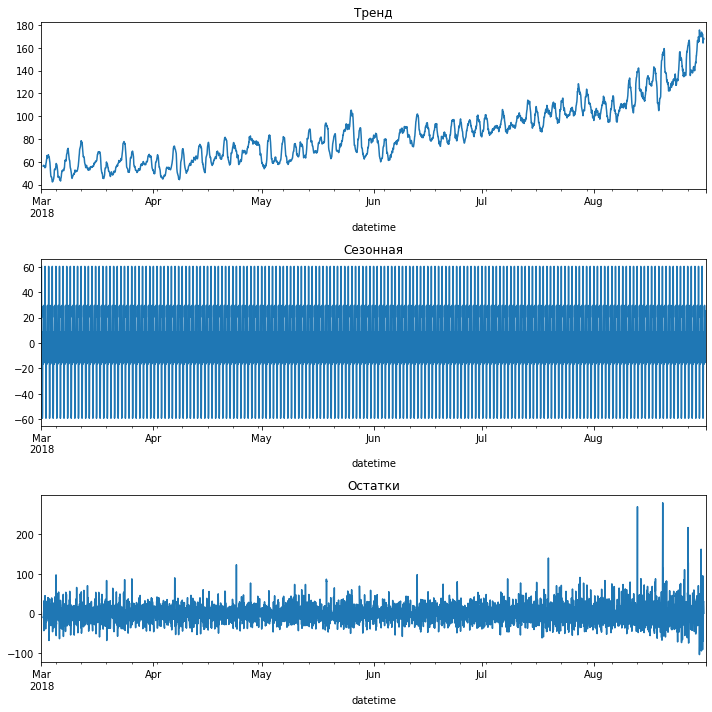

In [11]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(10,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

Мы видим восходящий тренд - летом чаще заказывают такси, возможно это связано с увеличением количества пассажиров в период отпусков. Посмотрим сезонность на графике за неделю и за сутки.

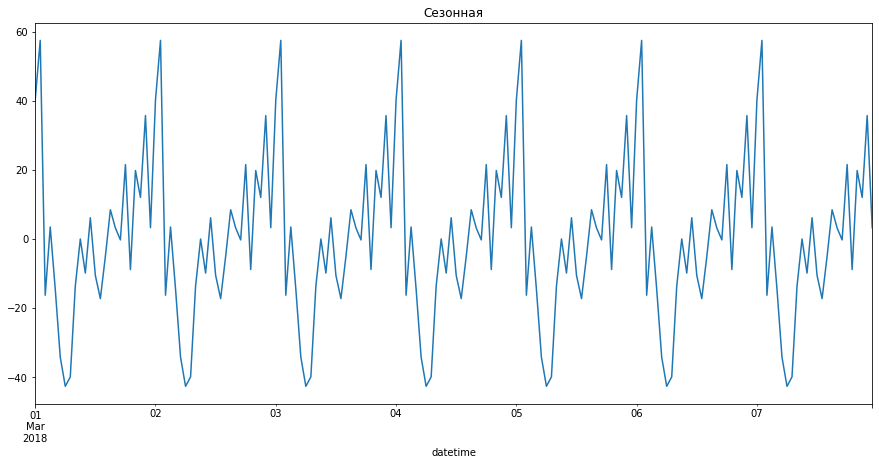

In [12]:
df_first_week_march = df['2018-03-01':'2018-03-07']
decomposed_first_week_march = seasonal_decompose(df_first_week_march['num_orders'])
plt.figure(figsize=(15,7))

decomposed_first_week_march.seasonal.plot()
plt.title('Сезонная')
plt.show()

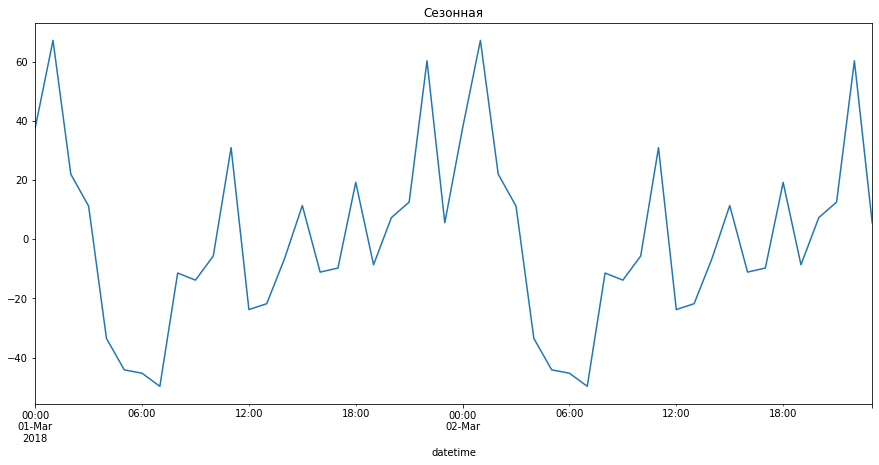

In [13]:
df_first_day_march = df['2018-03-01 00:00:00':'2018-03-02 23:00:00']
decomposed_first_day_march = seasonal_decompose(df_first_day_march['num_orders'])
plt.figure(figsize=(15,7))

decomposed_first_day_march.seasonal.plot()
plt.title('Сезонная')
plt.show()

В течение дня виден спад в утренние часы и увеличение количества заказов после 18-ти часов.

## Обучение

### Создание признаков

Напишем функцию для создания дополнительных параметров:

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [15]:
make_features(df, 4, 24)
df

,num_orders,rolling_mean,std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,66.0,71.0,85.0,124.0
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,63.268908,19,4,207.0,217.0,197.0,116.0
2018-08-31 20:00:00,154,167.541667,63.105487,20,4,136.0,207.0,217.0,197.0
2018-08-31 21:00:00,159,168.041667,62.801908,21,4,154.0,136.0,207.0,217.0


Разделим данные на обучающую и тестовую выборки в соотношении 90:10.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Приведём численные признаки к одному масштабу.

In [17]:
numeric = ['rolling_mean', 'std', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

(3950, 8)
(442, 8)


Поскольку во временных рядах нельзя использовать обычную кросс-валидацию, поэтому будем использовать TimeSeriesSplit:

### Линейная регрессия

In [18]:
%%time
# инициализируем модель
linreg = LinearRegression()

# задаем параметры для модуля GridSearch
param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}

tscv = TimeSeriesSplit(n_splits=4)

# ищем лучшие параметры 
grid_linreg = GridSearchCV(linreg, param_grid, cv=tscv, n_jobs = -1, scoring='neg_mean_squared_error')

# обучаем модель на тренировочных данных
grid_linreg.fit(features_train, target_train)

print('Лучшие параметры модели линейной регрессии:', grid_linreg.best_params_)
print('RMSE линейной регрессии:', grid_linreg.best_score_)
print()

Лучшие параметры модели линейной регрессии: {'fit_intercept': True, 'normalize': True}
RMSE линейной регрессии: -1050.7634348352929

CPU times: total: 93.8 ms
Wall time: 1.77 s


### Решающее дерево

In [19]:
%%time

# инициализируем модель
tree_reg = DecisionTreeRegressor(random_state=12345)

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10, 20],
 'min_samples_split': [8, 10, 12, 14, 16],
 }

tscv = TimeSeriesSplit(n_splits=4)

# ищем лучшие параметры 
grid_tree = GridSearchCV(estimator = tree_reg, 
                       param_grid = param_grid, 
                       cv= tscv, 
                       n_jobs = -1, 
                       scoring = 'neg_mean_squared_error') 

# обучаем модель на тренировочных данных
grid_tree.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели решающего дерева:', grid_tree.best_params_)
print()

# получаем лучшую оценку 
print('RMSE решающего дерева:', grid_tree.best_score_)
print()

Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 16}

RMSE решающего дерева: -879.2001051455024

CPU times: total: 93.8 ms
Wall time: 253 ms


### Случайный лес

In [20]:
%%time

# инициализируем модель
forest_reg = RandomForestRegressor(random_state=12345)

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10, 20],
 'n_estimators': [100, 200]
}

tscv = TimeSeriesSplit(n_splits=4)

# ищем лучшие параметры 
grid_forest = GridSearchCV(estimator = forest_reg, 
                            param_grid = param_grid, 
                            cv= tscv, 
                            n_jobs = -1, 
                            scoring='neg_mean_squared_error') 

# обучаем модель на тренировочных данных
grid_forest.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели случайного леса:', grid_forest.best_params_)
print()

# получаем лучшую оценку 
print('RMSE случайного леса:', grid_forest.best_score_)
print()

Лучшие параметры модели случайного леса: {'max_depth': 20, 'n_estimators': 200}

RMSE случайного леса: -706.2306000086286

CPU times: total: 2.81 s
Wall time: 8.35 s


### LightGBM

Поменяем тип данных в столбце "День недели" для модели градиентного бустинга LightGBM, для начала создадим копию исходного датафрейма.

In [21]:
df_lgbm = df.copy()

In [22]:
# меняем тип данных на category
categorial_columns = ['dayofweek']
df_lgbm[categorial_columns] = df_lgbm[categorial_columns].astype('category')
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   num_orders    4416 non-null   int64   
 1   rolling_mean  4392 non-null   float64 
 2   std           4393 non-null   float64 
 3   hour          4416 non-null   int64   
 4   dayofweek     4416 non-null   category
 5   lag_1         4415 non-null   float64 
 6   lag_2         4414 non-null   float64 
 7   lag_3         4413 non-null   float64 
 8   lag_4         4412 non-null   float64 
dtypes: category(1), float64(6), int64(2)
memory usage: 444.2 KB


Разделим данные на обучающую и тестовую выборки в соотношении 90:10

In [23]:
train_lgbm, test_lgbm = train_test_split(df_lgbm, shuffle=False, test_size=0.1)
train = train.dropna()

features_train_lgbm = train_lgbm.drop(['num_orders'], axis=1)
target_train_lgbm = train_lgbm['num_orders']
 
features_test_lgbm = test_lgbm.drop(['num_orders'], axis=1)
target_test_lgbm = test_lgbm['num_orders']

Приведём численные признаки к одному масштабу:

In [24]:
numeric = ['rolling_mean', 'std', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4']

scaler = StandardScaler()
scaler.fit(features_train_lgbm[numeric])
features_train_lgbm[numeric] = scaler.transform(features_train_lgbm[numeric])
features_test_lgbm[numeric] = scaler.transform(features_test_lgbm[numeric])

In [25]:
%%time
# инициализируем модель
model = LGBMRegressor(learning_rate = 0.1, n_jobs = -1, random_state=12345)

# задаем параметры для модуля GridSearch 
param_grid = {'max_depth': range(10, 21, 5),
              'n_estimators': range(10, 51, 10)}
  
tscv = TimeSeriesSplit(n_splits=4)

# ищем лучшие параметры 
grid_model = GridSearchCV(estimator = model, 
                            param_grid = param_grid, 
                            cv= tscv, 
                            n_jobs = -1, 
                            scoring= 'neg_mean_squared_error',
                            verbose = 10) 

# обучаем модель на тренировочных данных
grid_model.fit(features_train_lgbm, target_train_lgbm)

# получаем лучшие параметры модели
print('Лучшие параметры модели LGBMR:', grid_model.best_params_)
print()

# получаем лучшую оценку
print('RMSE для модели LGBMR:', grid_model.best_score_)
print()

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Лучшие параметры модели LGBMR: {'max_depth': 10, 'n_estimators': 50}

RMSE для модели LGBMR: -701.1607088345609

CPU times: total: 188 ms
Wall time: 756 ms


## Тестирование

### Линейная регрессия

Лучшие параметры модели линейной регрессии: {'fit_intercept': True, 'normalize': True}

In [26]:
%%time

# инициализируем модель
linreg = LinearRegression(fit_intercept = True, normalize = True)

# обучаем модель на тренировочной выборке
linreg.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_linreg = linreg.predict(features_test)

# оцениваем модель
rmse_linreg_test = mean_squared_error(target_test, predictions_linreg)**0.5
print('RMSE модели линейной регрессии:', rmse_linreg_test)
print()

RMSE модели линейной регрессии: 50.20197472578616

CPU times: total: 0 ns
Wall time: 4.99 ms


По условию задания RMSE на тестовой выборке должно быть не больше 48, поэтому модель линейной регрессии не подходит.

### Решающее дерево

Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 16}

In [27]:
%%time

# инициализируем модель
tree_reg = DecisionTreeRegressor(random_state=12345, max_depth = 10, min_samples_split = 16)

# обучаем модель на тренировочной выборке
tree_reg.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_tree = tree_reg.predict(features_test)

# оцениваем модель
rmse_tree_test = mean_squared_error(target_test, predictions_tree)**0.5
print('RMSE модели решающего дерева:', rmse_tree_test)
print()

RMSE модели решающего дерева: 49.960494665615805

CPU times: total: 78.1 ms
Wall time: 18 ms


Модель решающего дерева также не соответствует условию задачи.

### Случайный лес

Лучшие параметры модели случайного леса: {'max_depth': 20, 'n_estimators': 200}

In [28]:
%%time

# инициализируем модель
forest_reg = RandomForestRegressor(random_state=12345, max_depth = 20, n_estimators = 200)

# обучаем модель на тренировочной выборке
forest_reg.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_forest = forest_reg.predict(features_test)

# оцениваем модель
rmse_forest_test = mean_squared_error(target_test, predictions_forest)**0.5
print('RMSE модели случайного леса:', rmse_forest_test)
print()

RMSE модели случайного леса: 45.52978973096306

CPU times: total: 3.03 s
Wall time: 2.87 s


Модель случайного леса с RMSE 45,5 соответствует требованиям задания, посмотрим какое качество будет у модели LightGBM:

### LightGBM

Лучшие параметры модели LGBMR: {'max_depth': 10, 'n_estimators': 50}

In [29]:
%%time

# инициализируем модель
model_LGBM = LGBMRegressor(learning_rate = 0.1, n_jobs = -1, random_state=12345, max_depth = 10, n_estimators = 50)

# обучаем модель на тренировочной выборке
model_LGBM.fit(features_train_lgbm, target_train_lgbm)

# находим предсказания на тестовой выборке
predictions_LGBM = model_LGBM.predict(features_test_lgbm)

# оцениваем модель
rmse_LGBM_test = mean_squared_error(target_test_lgbm, predictions_LGBM)**0.5
print('RMSE для модели LGBMR:', rmse_LGBM_test)
print()

RMSE для модели LGBMR: 45.070449892260484

CPU times: total: 188 ms
Wall time: 37.9 ms


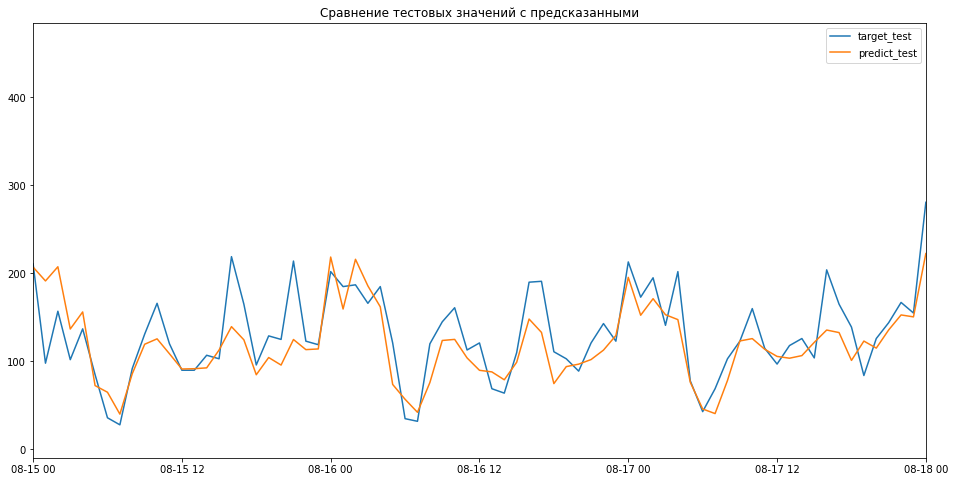

In [30]:
plt.figure(figsize=(16, 8))

plt.plot(target_test_lgbm, label='target_test')
plt.plot(target_test_lgbm.index, predictions_LGBM, label='predict_test')
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()

### Константная модель

Проверим модели на адекватность с помощью константной модели DummyRegressor.

In [31]:
# инициализируем модель
const = DummyRegressor(strategy='median')

# обучаем модель на тренировочных данных
const.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_const = const.predict(features_test)

# оцениваем модель
rmse_const = mean_squared_error(target_test, predictions_const)**0.5
print('RMSE для константной модели:', rmse_const)

RMSE для константной модели: 87.15277582981295


### Вывод

Cамые точные предсказания получили у модели LightGBM с гиперпараметрами 'max_depth': 10, 'n_estimators': 50. По сравнению с константной моделью RMSE модели градиентного бустинга LightGBM почти в два раза меньше и удовлетворяет условию задачи.

## Общий вывод

Объект нашего исследования - исторические данные о заказах такси в аэропортах.

В ходе предобработки мы подготовили данные к моделированию:
- убедились, что даты и время расположены в хронологическом порядке,
- выполнили ресемплирование данных по одному часу.

Для решения поставленной задачи мы создали дополнительные признаки, разделили данные на две выборки:
1. обучающую,
2. тестовую.

Обучили и проверили модели линейной регрессии, решающего дерева, случайного леса и модель градиентного бустинга LightGBM.

По результатам обучения мы проверили все модели на тестовых выборках и сравнили с константной моделью. Самые точные предсказания получили с помощью модели LightGBM, для которой RMSE на тестовой выборке: 45,07. Константная модель оказалась хуже почти в два раза, RMSE на тестовой выборке: 87,15.

Подведём итог нашей работы - рекомендация для компании "Чётенькое такси":
- чтобы привлекать больше водителей в период пиковой нагрузки рекомендуем использовать модель градиентного бустинга LightGBM с характеристиками:
    * max_depth = 10
    * n_estimators = 50. 